#Use Case D - Using BERT 

*    This is a Google Colab notebook. You must have a Google account with a Google Drive to store/ load the model. Upload it from its location in GitHub and allow the code to access your Google Drive.
*    Fine-tuning can be skipped if already run once. One can go to cell "Loading the fine-tuned model", load the saved model and continue.
*    See instructions in cell "Select Bi-encoder model" to change the bi-encoder model.
*    See instructions in cell "Choose input dataset" to change the inputs - full set of proposals (datasets or SE Glossary articles).

##Installations and imports

In [1]:
!pip install pyodbc

     |████████████████████████████████| 280 kB 5.2 MB/s 
  Created wheel for pyodbc: filename=pyodbc-4.0.32-cp37-cp37m-linux_x86_64.whl size=287362 sha256=e7b7205095b337303c003614f02a50c6d3945ee49506986ee68dba6eddb5334f
  Stored in directory: /root/.cache/pip/wheels/2e/9c/da/8652fd42e0f662015554f00a9e96fe4f438dfd1ef59787879e
Successfully built pyodbc


In [2]:
!apt-get install virtuoso-opensource

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libvirtodbc0 virtuoso-opensource-6.1 virtuoso-opensource-6.1-bin
  virtuoso-opensource-6.1-common virtuoso-server virtuoso-vad-conductor
  virtuoso-vsp-startpage
Suggested packages:
  virtuoso-vad-doc virtuoso-vad-demo virtuoso-vad-tutorial
  virtuoso-vad-rdfmappers virtuoso-vad-sparqldemo virtuoso-vad-syncml
  virtuoso-vad-bpel virtuoso-vad-isparql virtuoso-vad-ods virtuoso-vad-dbpedia
  virtuoso-vad-facetedbrowser
The following NEW packages will be installed:
  libvirtodbc0 virtuoso-opensource virtuoso-opensource-6.1
  virtuoso-opensource-6.1-bin virtuoso-opensource-6.1-common virtuoso-server
  virtuoso-vad-conductor virtuoso-vsp-startpage
0 upgraded, 8 newly installed, 0 to remove and 39 not upgraded.
Need to get 4,835 kB of archives.
After this operation, 27.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/

In [3]:
!pip install sentence-transformers

     |████████████████████████████████| 79 kB 3.5 MB/s 
     |████████████████████████████████| 4.0 MB 11.2 MB/s 
     |████████████████████████████████| 1.2 MB 37.1 MB/s 
     |████████████████████████████████| 77 kB 3.4 MB/s 
     |████████████████████████████████| 596 kB 36.9 MB/s 
     |████████████████████████████████| 6.6 MB 9.9 MB/s 
     |████████████████████████████████| 895 kB 27.7 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=19eec7fa792b3f1e6a7c3e5ab06668544c32175d00454c6b3c1ff77546f35cf9
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
import pandas as pd
import numpy as np
import re
import pyodbc
import nltk, os
import sklearn
import ipywidgets as widgets
import json
from sentence_transformers import SentenceTransformer, CrossEncoder, util
import torch
import random
import ast

from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

from collections import defaultdict
from sentence_transformers import SentenceTransformer, SentencesDataset
from sentence_transformers.losses import MultipleNegativesRankingLoss
from sentence_transformers.readers import LabelSentenceReader, InputExample
from torch.utils.data import DataLoader

from pathlib import Path
from google.colab import data_table, drive
from sentence_transformers import SentenceTransformer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

In [5]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

##Connect to the Virtuoso database

In [6]:
c = pyodbc.connect('DRIVER=/usr/lib/odbc/virtodbc.so;HOST=lod.csd.auth.gr:1111;UID=kimon;PWD=RkhvQYZ442e2JVXLHdtW;DATABASE=ESTAT')

In [7]:
#set encoding
c.setdecoding(pyodbc.SQL_CHAR, encoding='latin-1')
c.setencoding(encoding="latin-1")

In [8]:
cursor = c.cursor()

##Select Bi-encoder model
To run with the non-default choice, interrupt execution, select a model and then "run after" from the next cell.

In [9]:
# Load pre-trained model that we will use as a base for fine tuning
# By Default it loads the first option
# Warning: loading 2nd or 3rd model for finetuning requires large amounts of memory
bi_encoder_model_dropdown = widgets.Dropdown(options=["multi-qa-MiniLM-L6-cos-v1", "multi-qa-distilbert-cos-v1", "multi-qa-mpnet-base-cos-v1"])
display(widgets.HBox([widgets.Label(value="Bi-encoder model:"), bi_encoder_model_dropdown]))

In [10]:
#We use the Bi-Encoder to encode all passages, so that we can use it with semantic search
print('Using model: ',bi_encoder_model_dropdown.value)
bi_encoder = SentenceTransformer(bi_encoder_model_dropdown.value)

Using model:  multi-qa-MiniLM-L6-cos-v1


Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.22k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/383 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.8k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

## Load SE Glossary articles
*    Always loaded (even if fine-tuning is not run)
*    Definitions from dat_glossary.
*    Titles from dat_link_info (with resource_information_id=1, i.e. Eurostat, see ESTAT.V1.mod_resource_information).
*    Match above on id.

In [68]:
# The SE Glossary articles are always loaded (even if fine tuning is not run)
query = 'SELECT T1.id, T2.title, T1.definition, T2.url FROM ESTAT.V1.dat_glossary AS T1 INNER JOIN ESTAT.V1.dat_link_info AS T2 ON T1.id=T2.id WHERE T2.resource_information_id=1'
cursor.execute(query)
t1 = cursor.fetchall()
GL_df = pd.DataFrame.from_records(t1, columns=[x[0] for x in cursor.description])
# also keep a copy of this query results
glossary = GL_df.copy()


##Fine tuning

In [12]:
def clean(x, quotes=True):
    if pd.isnull(x): return x  
    x = x.strip()
    
    ## make letter-question mark-letter -> letter-quote-space-letter !!! but NOT in the lists of URLs!!!
    if quotes:
        x = re.sub(r'([A-Za-z])\?([A-Za-z])','\\1\' \\2',x) 
    
    ## make letter-question mark-space lower case letter letter-quote-space letter
    x = re.sub(r'([A-Za-z])\? ([a-z])','\\1\' \\2',x) 

    ## delete ,000 commas in numbers    
    x = re.sub(r'\b(\d+),(\d+)\b','\\1\\2',x) ## CORRECTED
    
    ## delete  000 spaces in numbers
    x = re.sub(r'\b(\d+) (\d+)\b','\\1\\2',x) ## CORRECTED
    
    ## remove more than one spaces
    x = re.sub(r' +', ' ',x)
    
    ## remove start and end spaces
    x = re.sub(r'^ +| +$', '',x,flags=re.MULTILINE) 
    
    ## space-comma -> comma
    x = re.sub(r' \,',',',x)
    
    ## space-dot -> dot
    x = re.sub(r' \.','.',x)
    
    x = re.sub(r'â.{2}',"'",x) ### !!! NEW: single quotes are read as: âXX
    
    return x

### Delete records with empty definitions and carry out data cleansing


In [13]:
GL_df['definition'] = GL_df['definition'].replace('', np.nan)
GL_df.dropna(axis=0,subset=['definition'],inplace=True)

GL_df.reset_index(drop=True, inplace=True)

GL_df['title'] = GL_df['title'].apply(clean)
GL_df['title'] = GL_df['title'].apply(lambda x: re.sub(r'\?','-',x)) ## also replace question marks by dashes
GL_df['definition'] = GL_df['definition'].apply(clean)

### Delete "special" records

* i.e. redirections.

In [14]:
# Drop The records with definitions "The revision ..." and "Redirect to ..." 

idx = GL_df[GL_df['definition'].str.startswith('The revision #')].index
GL_df.drop(idx , inplace=True)
idx = GL_df[GL_df['definition'].str.startswith('Redirect to')].index
GL_df.drop(idx , inplace=True)
# dropping some pairs that definition is something generic with a link 
idx = GL_df[GL_df['definition'].str.startswith('<Brief user-oriented definition')].index 
GL_df.drop(idx , inplace=True)

GL_df.reset_index(drop=True, inplace=True)

GL_df.rename(columns={'id':'article_id'},inplace=True)
GL_df.rename(columns={'definition':'content'},inplace=True)

### Add paragraphs titles and contents from the SE articles

* From dat_article_paragraph with abstract=0 (i.e. "no").
* Match article_id from dat_article_paragraph with id from dat_article.
* Carry out data cleansing on titles and paragraph contents.

In [15]:
query = 'SELECT article_id, title, content FROM ESTAT.V1.dat_article_paragraph WHERE abstract=0 AND article_id IN (SELECT id FROM ESTAT.V1.dat_article)'
cursor.execute(query)
t2 = cursor.fetchall()
add_content = pd.DataFrame.from_records(t2, columns=[x[0] for x in cursor.description])

In [16]:
add_content['title'] = add_content['title'].apply(clean)
add_content['content'] = add_content['content'].apply(clean)

add_content['title'] = add_content['title'].replace('', np.nan)
add_content = add_content.dropna(axis=0,subset=['title'])
add_content['content'] = add_content['content'].replace('', np.nan)
add_content = add_content.dropna(axis=0,subset=['content'])

### Query to get OECD Glossary data

In [17]:
query = "SELECT id, term,definition,context,theme FROM ESTAT.V1.OECD_Glossary"
OECD_df = pd.read_sql(query,c)
OECD_df['definition'] = OECD_df['definition'].apply(clean)

In [18]:
#apply cleaning
OECD_df['term'] = OECD_df['term'].apply(clean)
OECD_df['context'] = OECD_df['context'].apply(clean).apply(lambda x: re.sub(r'\. \. ','. ',x)).apply(lambda x: re.sub(r'\?','-',x)) ## also replace question marks by dashes
OECD_df['definition'] = OECD_df['definition'].apply(clean).apply(lambda x: re.sub(r'\. \. ','. ',x)).apply(lambda x: re.sub(r'\?','-',x)) ## also replace question marks by dashes

#renaming
OECD_df.rename(columns={'id':'article_id'},inplace=True)
OECD_df.rename(columns={'term':'title'},inplace=True)

# using title-definition pairs
OECD_df1 = OECD_df[['article_id','title','definition']]
OECD_df1 = OECD_df1.rename(columns={'definition':'content'})

# using title-context pairs
OECD_df2 = OECD_df[['article_id','title','context']].copy() ## avoid copy/slice warning
OECD_df2 = OECD_df2.rename(columns={'context':'content'})

OECD_df1 = OECD_df1[['article_id','title','content']].copy() ## avoid copy/slice warning
OECD_df2 = OECD_df2[['article_id','title','content']].copy() ## avoid copy/slice warning

# deleting empty
OECD_df1['content'] = OECD_df1['content'].replace('', np.nan)
OECD_df1 = OECD_df1.dropna(axis=0,subset=['content'])
OECD_df1['title'] = OECD_df1['title'].replace('', np.nan)
OECD_df1 = OECD_df1.dropna(axis=0,subset=['title'])

OECD_df2['content'] = OECD_df2['content'].replace('', np.nan)
OECD_df2 = OECD_df2.dropna(axis=0,subset=['content'])
OECD_df2['title'] = OECD_df2['title'].replace('', np.nan)
OECD_df2 = OECD_df2.dropna(axis=0,subset=['title'])

###Abstracts and context sections from SE articles

In [19]:
query = 'SELECT T1.id, T1.context, T2.title, T3.content FROM ESTAT.V1.dat_article as T1 INNER JOIN ESTAT.V1.dat_link_info as T2 ON T1.id=T2.id INNER JOIN ESTAT.V1.dat_article_paragraph as T3 ON T2.id=T3.article_id WHERE T2.resource_information_id=1 AND T3.abstract=1'
cursor.execute(query)
t2 = cursor.fetchall()
SE_df = pd.DataFrame.from_records(t2, columns=[x[0] for x in cursor.description])

In [20]:
SE_df.rename(columns={'id':'article_id','content':'abstract'},inplace=True)

In [21]:
# apply cleaning
SE_df['title'] = SE_df['title'].apply(clean).apply(lambda x: re.sub(r'\?','-',x)) ## also replace question marks by dashes
SE_df['context'] = SE_df['context'].apply(clean)
SE_df['abstract'] = SE_df['abstract'].apply(clean)

# using title-context pairs
SE_df1 = SE_df[['article_id','title','context']]
SE_df1 = SE_df1.rename(columns={'context':'content'})

# using title-abstract pairs
SE_df2 = SE_df[['article_id','title','abstract']]
SE_df2 = SE_df2.rename(columns={'abstract':'content'})

# deleting empty
SE_df1['content'] = SE_df1['content'].replace('', np.nan)
SE_df1 = SE_df1.dropna(axis=0,subset=['content'])

SE_df2['content'] = SE_df2['content'].replace('', np.nan).replace('nan', np.nan)
SE_df2 = SE_df2.dropna(axis=0,subset=['content'])

###Merging all available glossaries and articles

In [22]:
# merge OECD glossary with add_content, GL_df and SE_df
glossaries = [OECD_df1, OECD_df2, GL_df, add_content, SE_df1, SE_df2]
merged_glossary = pd.concat(glossaries, ignore_index=True)
merged_glossary = merged_glossary.drop(['url'],axis=1)

del(OECD_df1, OECD_df2, GL_df, add_content, SE_df1, SE_df2)

In [23]:
# setting all pairs of titles and content to have a label of 1
# this is because all pairs are considered a positive example
merged_glossary['is_pair']=1

### Keep 80% of data for training and 20% for evaluation of the model

In [24]:
from sklearn.model_selection import train_test_split
train_features, eval_features, train_labels, eval_labels = train_test_split(merged_glossary[['title','content']], 
                                                                            merged_glossary[['is_pair']], 
                                                                            train_size=0.8, 
                                                                            random_state=1,
                                                                            stratify=merged_glossary['is_pair'])

train_features = train_features.reset_index(drop=True)
eval_features = eval_features.reset_index(drop=True)

###Fine tuning bi-encoder (CUDA required)

In [25]:
# convert training examples to the appropriate format
train_examples = []
for i in range(len(train_features)):
  train_examples.append(InputExample(texts=[train_features['title'].iloc[i], train_features['content'].iloc[i]]))

In [26]:
finetune_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)

In [27]:
# MultipleNegativesRankingLoss is a great loss function if you only have positive pairs 
loss = MultipleNegativesRankingLoss(model=bi_encoder)

In [28]:
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, BinaryClassificationEvaluator, MSEEvaluator
from sentence_transformers import evaluation

sentences1 = list(eval_features['title'])
sentences2 = list(eval_features['content'])
scores_eval = list(eval_labels['is_pair'])

In [29]:
evaluator = evaluation.MSEEvaluator(sentences1, sentences2, teacher_model=bi_encoder)

In [30]:
#cleaning up any CUDA related left-overs
import gc
gc.collect()

100

In [31]:
# Fine-tune the model (BE CAREFUL TO SET A PATH FOR THE FINE-TUNED MODEL)

num_epochs = 10
bi_encoder.fit(train_objectives=[(finetune_dataloader, loss)], evaluator=evaluator, epochs=num_epochs,output_path='/content/drive/MyDrive/testing_fine_tuning')


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/744 [00:00<?, ?it/s]

Iteration:   0%|          | 0/744 [00:00<?, ?it/s]

Iteration:   0%|          | 0/744 [00:00<?, ?it/s]

Iteration:   0%|          | 0/744 [00:00<?, ?it/s]

Iteration:   0%|          | 0/744 [00:00<?, ?it/s]

Iteration:   0%|          | 0/744 [00:00<?, ?it/s]

Iteration:   0%|          | 0/744 [00:00<?, ?it/s]

Iteration:   0%|          | 0/744 [00:00<?, ?it/s]

Iteration:   0%|          | 0/744 [00:00<?, ?it/s]

Iteration:   0%|          | 0/744 [00:00<?, ?it/s]

##Loading the fine-tuned model

Run from here to skip the fine-tuning if already run.

In [72]:
fine_tuned_bi_encoder = SentenceTransformer('/content/drive/MyDrive/testing_fine_tuning')

In [73]:
bi_encoder = fine_tuned_bi_encoder

##Loading the datasets information from the database

In [74]:
query = 'SELECT id, number, codes, names, file_descr, file_code, level, link FROM ESTAT.V1.dat_all_datasets'
cursor.execute(query)
t1 = cursor.fetchall()
crumbs_df = pd.DataFrame.from_records(t1, columns=[x[0] for x in cursor.description])

crumbs_df['codes'] = crumbs_df['codes'].apply(lambda x: ast.literal_eval(x))
crumbs_df['names'] = crumbs_df['names'].apply(lambda x: ast.literal_eval(x))
crumbs_df.rename(columns={'number':'Number','codes':'Codes','names':'Names','file_descr':'File description',
                               'level':'Level','file_code':'File code','link':'Link'},inplace=True)

## keep only leaves - datasets
idx = crumbs_df[crumbs_df['File code']==''].index
crumbs_df.drop(index=idx, inplace=True) 
crumbs_df.reset_index(drop=True,inplace=True)

crumbs_df['Full path'] = crumbs_df['Names'].apply(lambda x: [y for y in x[1:]]) ## exclude first part
crumbs_df['Full path'] = crumbs_df['Full path'].apply(lambda x: ' '.join(x))

crumbs_df = crumbs_df[['Number','Codes','Names','File description','File code','Level','Full path','Link']]

In [75]:
# Drop duplicates with the same file code
crumbs_df = crumbs_df.drop_duplicates(subset='File code', keep="first").reset_index()

## Loading the SE Glossary articles from the database
*    Already loaded as glossary

In [76]:
## Skip if already run
if 'File description' not in glossary.columns:

    glossary['definition'] = glossary['definition'].replace('', np.nan)
    glossary.dropna(axis=0,subset=['definition'],inplace=True) ## inplace=True: avoid copy/slice warning

    glossary.reset_index(drop=True, inplace=True)

    glossary['title'] = glossary['title'].apply(clean)
    glossary['title'] = glossary['title'].apply(lambda x: re.sub(r'\?','-',x)) ## also replace question marks by dashes
    # Edit titles in order to remove "Glossary:"
    glossary['title'] = glossary['title'].apply(lambda x: re.sub(r'Glossary:',' ',x)) 
    glossary['definition'] = glossary['definition'].apply(clean)

In [77]:
## Skip if already run
if 'File description' not in glossary.columns:
    # Drop The records with definitions "The revision ..." and "Redirect to ..." 
    idx = glossary[glossary['definition'].str.startswith('The revision #')].index
    glossary.drop(idx , inplace=True)
    idx = glossary[glossary['definition'].str.startswith('Redirect to')].index
    glossary.drop(idx , inplace=True)
    # dropping some pairs that definition is something generic with a link 
    idx = glossary[glossary['definition'].str.startswith('<Brief user-oriented definition')].index 
    glossary.drop(idx , inplace=True)

    glossary.reset_index(drop=True, inplace=True)

In [78]:
## Skip if already run
if 'File description' not in glossary.columns:
    glossary.rename(columns={'id':'article_id'},inplace=True)
    glossary.rename(columns={'url':'Link'},inplace=True)
    glossary.rename(columns={'definition':'File description'},inplace=True)

    glossary['Full path'] = glossary['title'] + '. ' + glossary['File description']

##Save datasets and SE Glossary articles data

In [79]:
# save Eurostat's datasets to pickle 
crumbs_df.to_pickle('/content/drive/MyDrive/datasets_use_case_d.pkl')

In [80]:
# save glossary articles to pickle 
glossary.to_pickle('/content/drive/MyDrive/glossary_use_case_d.pkl')

##Choose input dataset
To run with the non-default choice, interrupt execution, select the second choice and then "run after" from the next cell. 

In [81]:
# By Default it loads the first option

input_dataset_dropdown = widgets.Dropdown(options=["datasets_use_case_d.pkl", "glossary_use_case_d.pkl"])
display(widgets.HBox([widgets.Label(value="Input dataset:"), input_dataset_dropdown]))



In [91]:
#We use the Bi-Encoder to encode all passages, so that we can use it with sematic search
print('Using ',input_dataset_dropdown.value)
datasets_path = '/content/drive/MyDrive/' + input_dataset_dropdown.value
crumbs_df = pd.read_pickle(datasets_path)

Using  glossary_use_case_d.pkl


##Calculate corpus embeddings in advance

In [92]:
# We encode all corpus into our vector space, using "Full path" column. 
corpus_embeddings_full = bi_encoder.encode(crumbs_df['Full path'], convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/40 [00:00<?, ?it/s]

In [93]:
crumbs_df['embeddings'] = list(corpus_embeddings_full.cpu())

In [94]:
#pre-download cross-encoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

## Functions

In [95]:
# A function that returns the most relevant datasets (along with some other data)
def relevant_datasets(query, data_df, howmany, top_k=100):

    data_df = data_df[['File description', 'Full path', 'Link', 'embeddings']].reset_index(drop=True).copy()
    # Encode query into our vector space 
    question_embedding = bi_encoder.encode(query, convert_to_tensor=True)
    #top_k  refers to number of Eurostat databases we want to retrieve with the bi-encoder
    hits = util.semantic_search(question_embedding, torch.stack(data_df['embeddings'].values.tolist()), top_k=top_k)
    hits = hits[0]  # Get the hits for the first query
    hits_df = pd.DataFrame(hits)

    data_df['corpus_id'] = data_df.index
    data_df = hits_df.merge(data_df, on='corpus_id', how='inner')

    #Re-ranking
    #Loading a cross-encoder model, and re-ranking the results of the bi-encoder
    #Cross-Encoder achieve higher performance than Bi-Encoders, however, they do not
    #scale well for large datasets. Here, it can make sense to combine Cross- and
    #Bi-Encoders, for Semantic Search scenarios: 
    #First, you use an efficient Bi-Encoder to retrieve e.g. the top-100 most
    #similar sentences for a query. Then, you use a Cross-Encoder to re-rank
    #these 100 hits by computing the score for every (query, hit) combination.

    # Now, score all retrieved passages with the cross_encoder
    cross_inp = [[query, data_df['Full path'][hit]] for hit in range(len(data_df))]

    data_df['cross_scores'] = cross_encoder.predict(cross_inp)
    data_df = data_df.sort_values(['cross_scores'],ascending=False)
    results = data_df[['cross_scores', 'score','File description', 'Full path', 'Link', 'embeddings' ]].head(howmany)

    return results

In [96]:
# Notion behind this function is that when user answers 'no' to a proposed ngram
# or replies with their own phrase, then they might be interested in more generic
# ngram (e.g. if asked 'educational attainment level' and answered 'no', might
# be interested in 'educational' solely). # Simultaneously, the user would not
# want to see a more specific ngram (e.g. if asked for 'unemployment rate', wouldn't
# be interested in 'unemployment rate by sex').
# This function is used when we want to find all similar terms to input_term,
# against the terms_list. We seek similar terms in terms_list.  If input term is
# a subset of a (stemmed) term in the terms_list, then this is considered as similar.
# Example:
# input_term = unemployment rate
# terms_list = [unemployment rate, unemployment rates, unemployment, rate, harmonised unemployment rate]
# indices_list = [0,1,4]
def indices_of_similar_subset_terms(terms_list, input_term):
  # define stop words language
  stop_words = stopwords.words('english')

  # input_term might be 1 or more tokens (usually words, numbers, etc)
  tokens = input_term.split()
  # get all unique input tokens that are not stopwords
  tokens = set(filter(lambda o: not o in stop_words, tokens))
  if len(tokens)==0:
    return []
  
  # get the unique stemmed tokens
  stemmer = PorterStemmer()
  stemmed_tokens = set(map(lambda o: stemmer.stem(o), tokens))

  # for every term in the term_list get all
  indices_list = []
  for i,term in enumerate(terms_list):
    stemmed_term = set(map(lambda o: stemmer.stem(o), term.split()))
    # issubset returns true if stemmed_tokens is a subset of stemmed_term
    if stemmed_tokens.issubset(stemmed_term):
      indices_list.append(i)
    
  return indices_list

# Notion behind this function is that when user answers 'yes' to a proposed ngram,
# then they might be interested in more specific ngram (e.g. if asked
# 'unemployment rate', would be interested in 'harmonised unemployment rate' also).
# Simultaneously, the user would not want to see a repetition of a less specific ngram
# (e.g. if asked for 'unemployment rate', wouldn't be interested in either
# 'unemployment' or 'rates' to be asked again).
# This function is used when we want to find all similar terms to input_term,
# against the terms_list. We seek similar terms in terms_list.  If input term is
# a superset of a (stemmed) term in the terms_list, then this is considered as similar.
# Example:
# input_term = unemployment rate
# terms_list = [unemployment rate, unemployment rates, unemployment, rate, harmonised unemployment rate]
# indices_list = [0, 1, 2, 3]
def indices_of_similar_superset_terms(terms_list, input_term):
  stop_words = stopwords.words('english')

  tokens = input_term.split() 
  tokens = set(filter(lambda o: not o in stop_words, tokens))
  if len(tokens)==0:
    return []
  stemmer = PorterStemmer()
  stemmed_tokens = set(map(lambda o: stemmer.stem(o), tokens))

  indices_list = []
  for i,term in enumerate(terms_list):
    stemmed_term = set(map(lambda o: stemmer.stem(o), term.split()))
    stemmed_term = set(filter(lambda o: not o in stop_words, stemmed_term))
    if stemmed_tokens.issuperset(stemmed_term):
      indices_list.append(i)
    
  return indices_list

# remove 'by' if it is the last token
def clean_term_to_show(input_term):
  tokens = input_term.split()
  if tokens[-1]=='by':
    return ' '.join(tokens[:-1])
  return input_term

# function to produce a random question 
def choose_question(input_term):
  
  input_tokens = input_term.split()
  # if ngram starts with 'by'
  if input_tokens[0]=='by':
    question_texts = [f"Would you like to see results {input_term}?", 
                      f"Would you be interested in seeing results {input_term}?",  
                      f"Let's make it more specific. Are you interested in seeing results {input_term}?"]
  # if ngram contains 3 or more tokens (this means that the question becomes very specific)  
  elif len(input_tokens)>=3:
    question_texts = [f"What about {input_term}?"]
  else:
    question_texts = [f"Can we make it more specific? Is '{input_term}' related to what you are looking for?", 
                      f"Let's make it more specific. Are you interested in '{input_term}'?",
                      f"I have some results related to '{input_term}'. Is that what you are looking for?",
                      f"It would help me if could be could be more specific. Is '{input_term}' related to what you are searching?",
                      f"Would you be interested in '{input_term}'?",
                      f"Is '{input_term}' related to what you are looking for?",
                      f"It would help me if you could provide more details. Is '{input_term}' something related to your query?",
                      f"Please provide more details. Is '{input_term}' something related to what you are looking for?",
                      f"Are you interested to results related to '{input_term}'?",
                      f"Help me please to understand what you mean. Are you referring to '{input_term}'"
    ]
  return random.choice(question_texts)

# generate a list tha contains all 1 to 4 ngrams from input_text
def generate_ngrams(input_text):
  vectorizer1 = TfidfVectorizer(ngram_range=(1, 4))
  _ = vectorizer1.fit([input_text])
  input_ngrams = list(vectorizer1.get_feature_names_out())
  return input_ngrams

# function to create histograms of 2 clusters (for K-mean results)
def create_plot(datasets):
  # use a gray background
  ax = plt.axes(facecolor='#E6E6E6')
  ax.set_axisbelow(True)

  # draw solid white grid lines
  plt.grid(color='w', linestyle='solid')

  # hide axis spines
  for spine in ax.spines.values():
      spine.set_visible(False)
      
  # hide top and right ticks
  ax.xaxis.tick_bottom()
  ax.yaxis.tick_left()

  # lighten ticks and labels
  ax.tick_params(colors='gray', direction='out')
  for tick in ax.get_xticklabels():
      tick.set_color('gray')
  for tick in ax.get_yticklabels():
      tick.set_color('gray')

  ax.hist(datasets['cross_scores'][(datasets['cluster_id'] == 0)], 5, density=False, histtype='bar',  label='cluster 1')
  ax.hist(datasets['cross_scores'][(datasets['cluster_id'] == 1)], 5, density=False, histtype='bar',  label='cluster 2')
  ax.legend(prop={'size': 10})
  ax.set_xlabel('cross_scores')
  ax.set_title('Reduction phase, K-means clusters histogram')
  plt.pause(0.05)
  return ax

##Chatbot

In [97]:
stop_words = stopwords.words('english')
# exclude 'by' from stopwords (as we think that carries useful information)
stop_words.remove('by')

In [98]:
def chatbot(crumbs_df, stopwords, howmany_v, stop_after_multiple_no, stop_after_multiple_yes,show_inter_results):
  no_words = []
  input_text = input("bot: Hello, what are you looking for? \nme:  ")
  query_results_df = relevant_datasets(input_text, data_df=crumbs_df, howmany=howmany_v)

  # keep asking the user for clarifications up until the results<=5, or if the user replied a total of 6 'no'
  while stop_after_multiple_yes>0 and stop_after_multiple_no>0:

    # perform kmeans with 2 clusters on cross_scores, and only keep the cluster that contains the result with best cross-score
    kmeans = KMeans(n_clusters=2, random_state=42).fit(query_results_df[['cross_scores']])
    query_results_df['cluster_id'] =  list(kmeans.labels_)
    # display clustering results
    
    if show_inter_results: 
        ax = create_plot(query_results_df)
        display(ax)
    
    # reduce proposals
    query_results_df = query_results_df[query_results_df['cluster_id']==(query_results_df['cluster_id'].iloc[0])]

    if len(query_results_df)<=5:
      break

    # display intermediate results
    if show_inter_results: 
        display(data_table.DataTable(query_results_df.drop(['embeddings'], axis=1), num_rows_per_page=10))

    vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(2, 4), max_df=0.89, min_df=0.02, token_pattern='(?u)\\b\\w*[a-zA-Z#$%&-/<=>]\\w*\\b')
    subset = vectorizer.fit_transform(query_results_df['File description'])
    # dictionary that containes all possible 2-4 ngrams that have been produced by datasets descriptions
    words_dict = vectorizer.vocabulary_

    # get all 1-4 ngrams from the user input
    input_text2words = generate_ngrams(input_text)
    # list of all ngrams that we don't want to propose (either the ones that user said no, or anything related to their query)
    all_unwanted_words = input_text2words + no_words

    # a vocublulary of tokens that includes all ngrams that have been produced 
    vocabulary_words = vectorizer.get_feature_names_out()

    # decide on the order that we want to show the user the ngrams (in the clarification question)
    sorted_word_idx = list(np.argsort(np.mean(subset.toarray(), axis=0)))

    # get the index of all unwanted words that are in the words dictionary
    existing_idx = list(map(lambda o: words_dict[o], filter(lambda o: o in words_dict, all_unwanted_words)))

    while stop_after_multiple_no>0:

      # get the best ngram, according to tf-idf, that is not in unwanted words
      question_word_idx = [x for x in sorted_word_idx if x not in existing_idx][-1]
      question_word = vocabulary_words[question_word_idx]

      cleaned_term = clean_term_to_show(question_word)
      # making sure that the cleaned term will be removed from ngrams to propose, and added to unwanted words 
      if cleaned_term in all_unwanted_words:
        no_words.append(cleaned_term)
        sorted_word_idx.remove(question_word_idx)
        continue

      answer_text = input(f"bot: {choose_question(cleaned_term)} (yes/no or add some keywords) \nme:  ") 

      if answer_text.lower()=='yes':
        # stop if you reach a threshold for "yes" answers from the user
        stop_after_multiple_yes = stop_after_multiple_yes - 1

        #update the initial query with the new ngram that we proposed (question_word)
        input_text = input_text + ' ' + question_word
        # find all terms that are similar to that ngram proposed
        similar_terms_idx = indices_of_similar_superset_terms(vocabulary_words, question_word)
        # add all similar terms to the unwanted words
        no_words.extend(list(map(lambda o: vocabulary_words[o], similar_terms_idx)))

        for similar_term_idx in similar_terms_idx:
          # remove all similar terms from the vocabulary that we use to propose new ngrams
          if similar_term_idx in sorted_word_idx: 
            sorted_word_idx.remove(similar_term_idx)
        break

      elif answer_text.lower()=='no':
        # stop if you reach a threshold for "no" answers from the user
        stop_after_multiple_no = stop_after_multiple_no - 1

        # find all terms that are similar to that ngram proposed  
        similar_terms_idx = indices_of_similar_subset_terms(vocabulary_words, question_word)
        # add all similar terms to the unwanted words
        no_words.extend(list(map(lambda o: vocabulary_words[o], similar_terms_idx)))

        # remove all similar terms from the vocabulary that we use to propose new ngrams
        for similar_term_idx in similar_terms_idx:
          if similar_term_idx in sorted_word_idx:
            sorted_word_idx.remove(similar_term_idx)

      # user can quit at any time
      elif answer_text.lower()=='q':
        stop_after_multiple_no = 0
        break

      # in case that the user has entered a keyword/phrase/sentence instead of answering yes/no  
      else:
        stop_after_multiple_yes = stop_after_multiple_yes - 1

        #update the initial query with the new ngram that we proposed (question_word)
        input_text = input_text + ' ' + answer_text
        # get all ngrams from the user's answer 
        answer_text2words = generate_ngrams(answer_text)
        # for every token that the user's answer contain
        for token in answer_text2words:
          # find all terms that are similar to the user's answer  
          similar_terms_idx = indices_of_similar_superset_terms(vocabulary_words, token)
          # add all similar terms to the unwanted words
          no_words.extend(list(map(lambda o: vocabulary_words[o], similar_terms_idx)))

          # remove all similar terms from the vocabulary that we use to propose new ngrams
          for similar_term_idx in similar_terms_idx:
            if similar_term_idx in sorted_word_idx:
              sorted_word_idx.remove(similar_term_idx)
        break
    
    # get the updated results based on the augmented user's answer
    query_results_df = relevant_datasets(input_text, data_df=query_results_df, howmany=howmany_v)

  # final results (truncated so as to show only top5 to the user)
  query_results_df = query_results_df.head(5)
  print('bot: Thank you. Here are the most relevant results of your query:')
  
  return query_results_df

## After the end of a conversation re-run the cell below to start a new one.

bot: Hello, what are you looking for? 
me:  migrants


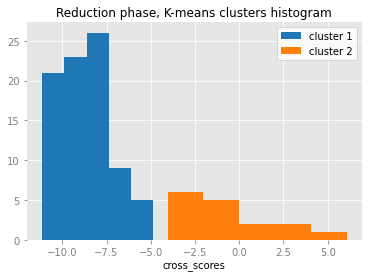

,cross_scores,score,File description,Full path,Link,cluster_id
0,6.063701,0.524512,"Migration refers to the number of migrants, pe...",Migration. Migration refers to the number of m...,https://ec.europa.eu/eurostat/statistics-expla...,1
1,3.817848,0.524362,"Migrant transfer is, in BPM5 (Balance of Payme...","Migrant transfer. Migrant transfer is, in BPM5...",https://ec.europa.eu/eurostat/statistics-expla...,1
5,2.359676,0.487100,"A refugee means a third-country national who, ...",Refugee. A refugee means a third-country natio...,https://ec.europa.eu/eurostat/statistics-expla...,1
8,0.827208,0.425372,Residence in the context of balance of payment...,Residence. Residence in the context of balance...,https://ec.europa.eu/eurostat/statistics-expla...,1
3,0.587264,0.495171,An asylum seeker is an asylum applicant awaiti...,Asylum seeker. An asylum seeker is an asylum a...,https://ec.europa.eu/eurostat/statistics-expla...,1
15,-0.076268,0.343924,Workers' remittance was defined in the Balance...,Workers remittance. Workers' remittance was de...,https://ec.europa.eu/eurostat/statistics-expla...,1
14,-0.207132,0.345966,Remittances is household income being generate...,Remittances. Remittances is household income b...,https://ec.europa.eu/eurostat/statistics-expla...,1
18,-0.455530,0.324418,Asylum is a form of protection given by a stat...,Asylum. Asylum is a form of protection given b...,https://ec.europa.eu/eurostat/statistics-expla...,1
55,-0.538356,0.204510,An asylum procedure where an asylum applicant ...,Asylum decision. An asylum procedure where an ...,https://ec.europa.eu/eurostat/statistics-expla...,1
13,-1.032706,0.360574,An application for international protection re...,Application for international protection. An a...,https://ec.europa.eu/eurostat/statistics-expla...,1


bot: I have some results related to 'international protection'. Is that what you are looking for? (yes/no or add some keywords) 
me:  yes


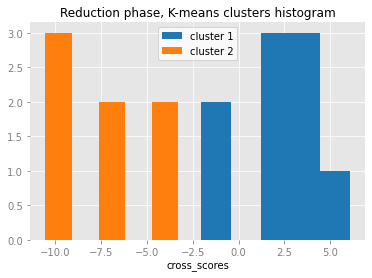

,cross_scores,score,File description,Full path,Link,cluster_id
0,6.064342,0.639821,An application for international protection re...,Application for international protection. An a...,https://ec.europa.eu/eurostat/statistics-expla...,0
4,4.335363,0.429720,An asylum seeker is an asylum applicant awaiti...,Asylum seeker. An asylum seeker is an asylum a...,https://ec.europa.eu/eurostat/statistics-expla...,0
1,4.120141,0.482004,First-time asylum applicants for international...,First time asylum applicant. First-time asylum...,https://ec.europa.eu/eurostat/statistics-expla...,0
12,3.507879,0.319622,"Migration refers to the number of migrants, pe...",Migration. Migration refers to the number of m...,https://ec.europa.eu/eurostat/statistics-expla...,0
10,2.660655,0.334570,An asylum procedure where an asylum applicant ...,Asylum decision. An asylum procedure where an ...,https://ec.europa.eu/eurostat/statistics-expla...,0
2,2.357489,0.448545,Asylum is a form of protection given by a stat...,Asylum. Asylum is a form of protection given b...,https://ec.europa.eu/eurostat/statistics-expla...,0
6,1.896257,0.380814,Asylum applicant refers to a person having sub...,Asylum applicant. Asylum applicant refers to a...,https://ec.europa.eu/eurostat/statistics-expla...,0
3,-1.495373,0.445303,"A refugee means a third-country national who, ...",Refugee. A refugee means a third-country natio...,https://ec.europa.eu/eurostat/statistics-expla...,0
5,-2.034092,0.384354,"Migrant transfer is, in BPM5 (Balance of Payme...","Migrant transfer. Migrant transfer is, in BPM5...",https://ec.europa.eu/eurostat/statistics-expla...,0


bot: It would help me if could be could be more specific. Is 'reference period' related to what you are searching? (yes/no or add some keywords) 
me:  no
bot: What about application international protection? (yes/no or add some keywords) 
me:  yes


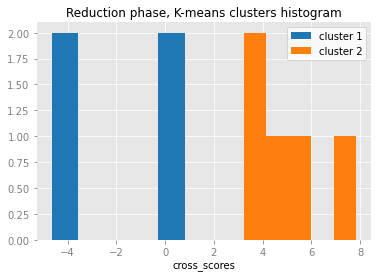

bot: Thank you. Here are the most relevant results of your query:


,cross_scores,score,File description,Full path,Link,cluster_id
0,7.834195,0.724541,An application for international protection re...,Application for international protection. An a...,https://ec.europa.eu/eurostat/statistics-expla...,1
1,5.766075,0.512342,First-time asylum applicants for international...,First time asylum applicant. First-time asylum...,https://ec.europa.eu/eurostat/statistics-expla...,1
4,4.547930,0.406451,An asylum seeker is an asylum applicant awaiti...,Asylum seeker. An asylum seeker is an asylum a...,https://ec.europa.eu/eurostat/statistics-expla...,1
2,3.816651,0.455482,Asylum applicant refers to a person having sub...,Asylum applicant. Asylum applicant refers to a...,https://ec.europa.eu/eurostat/statistics-expla...,1
5,3.217153,0.372500,An asylum procedure where an asylum applicant ...,Asylum decision. An asylum procedure where an ...,https://ec.europa.eu/eurostat/statistics-expla...,1


In [99]:
show_inter_results = True ## Show intermediate results
## Change this to False to hide these

query_results_df = chatbot(crumbs_df, stopwords, howmany_v=100, stop_after_multiple_no=6, stop_after_multiple_yes=5,show_inter_results=show_inter_results)

display(data_table.DataTable(query_results_df.drop(['embeddings'], axis=1), num_rows_per_page=10))